# Extending Logistic Regression
By: <ul>
<li> Rebecca Kuhlman </li>
<li> Sam Yao </li>
<li> Micheal Amberg</li>
</ul>

<h2>Preparation and Overview</h2>

    [2 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis? As in previous labs, also detail how good the classifier needs to perform in order to be useful.
    [.5 points] (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Provide a breakdown of the variables after preprocessing (such as the mean, std, etc. for all variables, including numeric and categorical).
    [.5 points] Divide your data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?

Contraception use is a widely used indicator of women's rights in an area. Understanding the demographics that most commonly do not use contraception is a step to being able to educate that demographics to take control over a very important part of their life. A prediction algorithm may be useful to health care providers to suggest more education material.

We will be classifying between no contraception, long-term method, and short-term method. Long term methods last from 3 months to 10 years and include intrauterine devices, shots, and implants. Short-term methods include condoms and barrier methods, the pill, the patch, and the ring (which is removed and replaced every menstrual cycle). Finding whether a certain person prefers short-term versus long-term depends on their circumstances would also be helpful. If women in a urban area favored long-term contraception, that information would help companies advertise more effectively.

This dataset is of married indonesian cis-women of fertile age, and can only be applied to that demographic. The stakes of accuracy are a bit complex. On one hand, the downside of providing more information to a demographic that doesn't necessary need it is cost, while not providing as much information on contraception can be detrimental, but ideally all would give some level of information acceptable. An 80% accuracy rate would be acceptable for this task.

A model could be deployed for health care providers in Indonesia to use in identifying patients to educate about contraception, or for companies to use to see which areas to better advertise different forms of contraception.

Attribute Information:

   1. Wife's age                     (numerical) - INT
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical) - INT
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
      -What the categories were mapped to is unknown
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use
                                                        2=Long-term
                                                        3=Short-term

Note on the religion attribute: the vast majority of Indonesians are Muslim

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data",
                 names=["Wife's age","Wife's education","Husband's education",
                        "Number of children","Religion","Wife's working?"
                        ,"Husband's occupation","Standard-of-living index","Media exposure", "Contraceptive method used"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Wife's age                 1473 non-null   int64
 1   Wife's education           1473 non-null   int64
 2   Husband's education        1473 non-null   int64
 3   Number of children         1473 non-null   int64
 4   Religion                   1473 non-null   int64
 5   Wife's working?            1473 non-null   int64
 6   Husband's occupation       1473 non-null   int64
 7   Standard-of-living index   1473 non-null   int64
 8   Media exposure             1473 non-null   int64
 9   Contraceptive method used  1473 non-null   int64
dtypes: int64(10)
memory usage: 115.2 KB
None


In [2]:
print(df.describe())

        Wife's age  Wife's education  Husband's education  Number of children  \
count  1473.000000       1473.000000          1473.000000         1473.000000   
mean     32.538357          2.958588             3.429735            3.261371   
std       8.227245          1.014994             0.816349            2.358549   
min      16.000000          1.000000             1.000000            0.000000   
25%      26.000000          2.000000             3.000000            1.000000   
50%      32.000000          3.000000             4.000000            3.000000   
75%      39.000000          4.000000             4.000000            4.000000   
max      49.000000          4.000000             4.000000           16.000000   

          Religion  Wife's working?  Husband's occupation  \
count  1473.000000      1473.000000           1473.000000   
mean      0.850645         0.749491              2.137814   
std       0.356559         0.433453              0.864857   
min       0.000000        

<AxesSubplot: xlabel="Husband's occupation", ylabel='Count'>

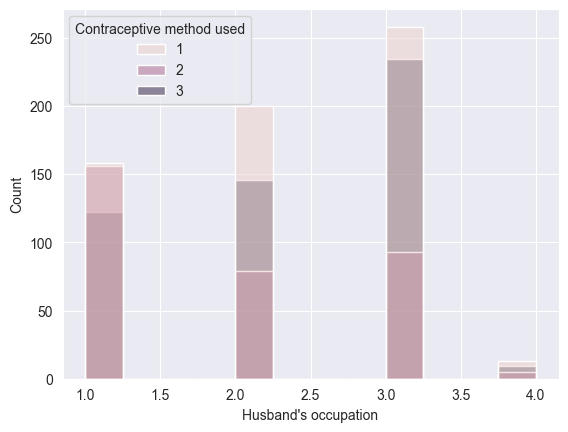

In [3]:
sns.histplot(df, x="Husband's occupation", hue="Contraceptive method used")

We are unsure of what husband's occupation numbers mean in the data set, even after research. The data appears to be skewed, and husband's education is linked to occupation. In conclusion, we will remove this column from the dataset.

<AxesSubplot: xlabel="Husband's education", ylabel='Count'>

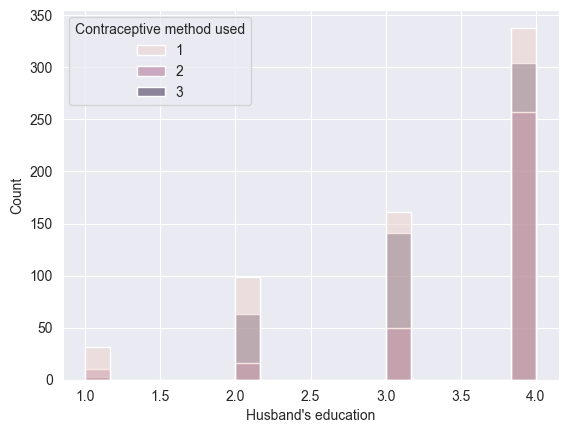

In [4]:
sns.histplot(df, x="Husband's education", hue="Contraceptive method used")

<AxesSubplot: xlabel='Religion', ylabel='Count'>

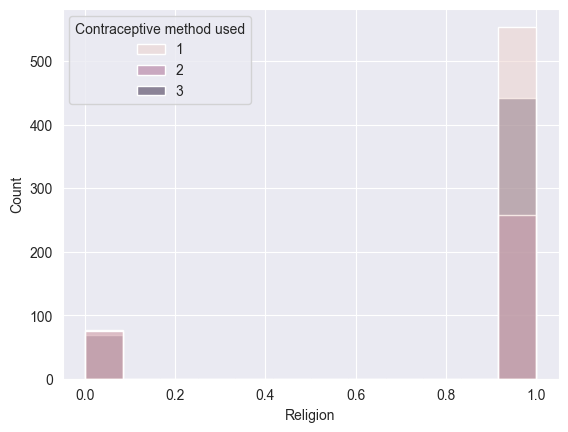

In [5]:
sns.histplot(df, x="Religion", hue="Contraceptive method used")

The vast majority of people in Indonesians are Muslim, leading the sample size of non-muslims to be quite small in comparison. Because of this, we will take religion out of the dataset.

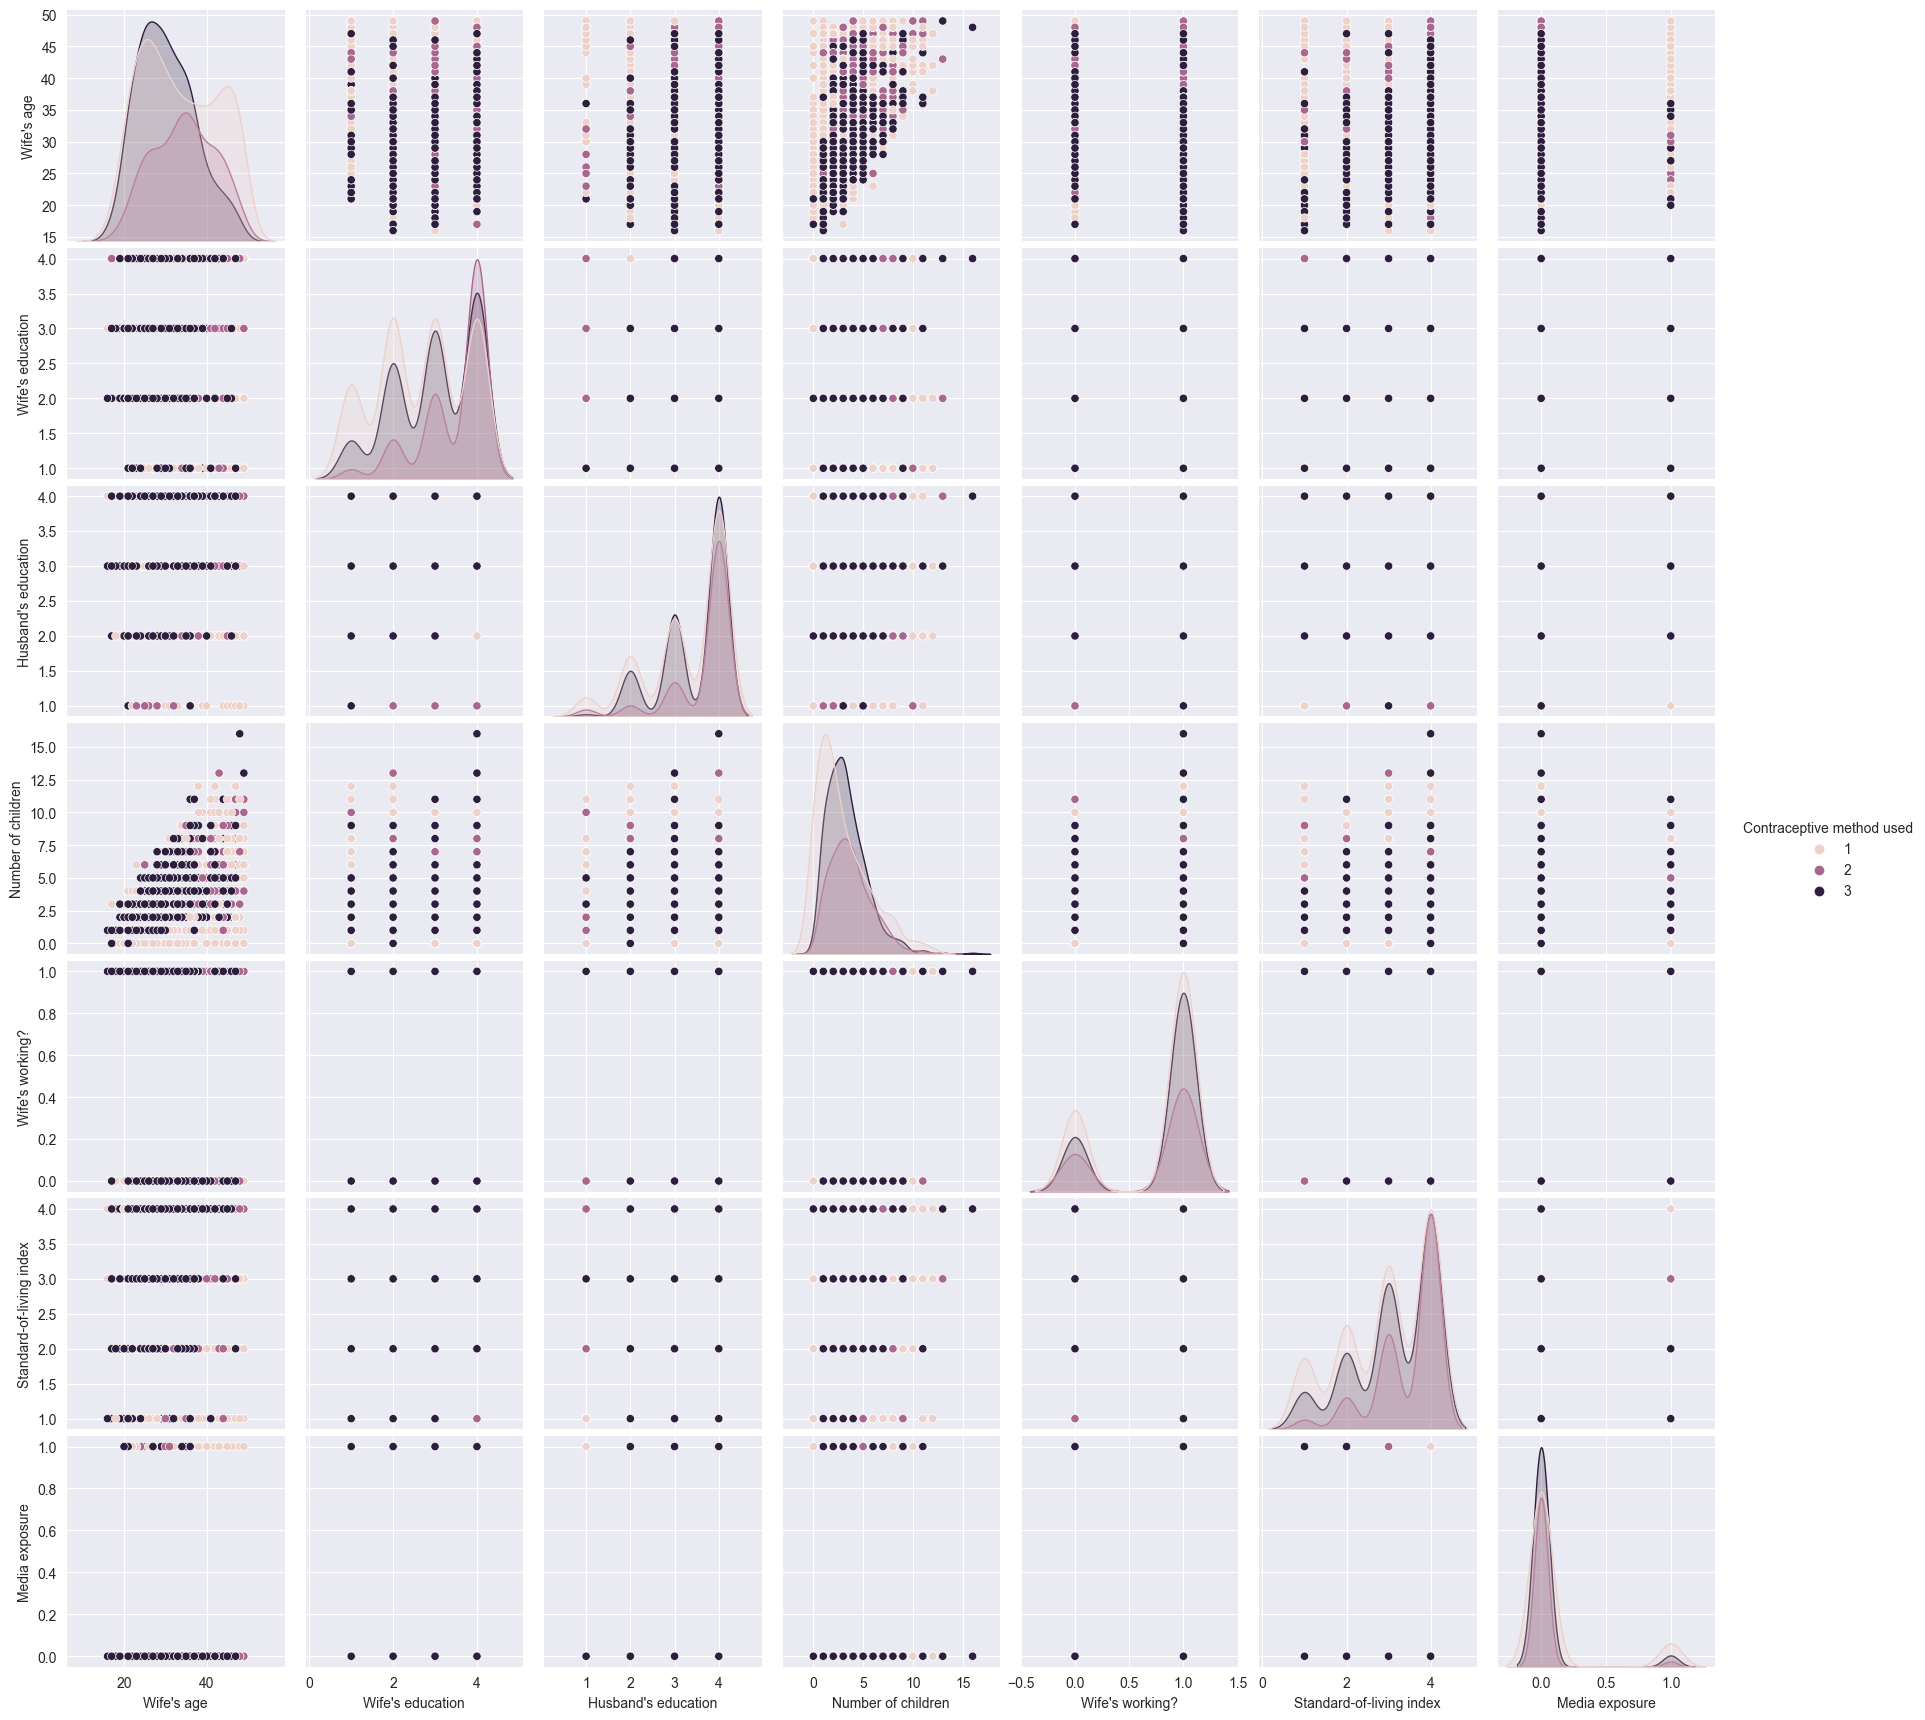

In [6]:
sns.pairplot(df, hue="Contraceptive method used", vars=("Wife's age","Wife's education","Husband's education",
                        "Number of children","Wife's working?","Standard-of-living index","Media exposure"))

All other attributes have sufficient impact on contraceptive use and will be used to build the model.

In [7]:
'''def get_z_score(num, min, max):
    return (num - min) / (max - min)
scaledAges = []
scaledKids = []

for x in df["Wife's age"]:
    scaledAges.append(get_z_score(x, 16, 49))
for x in df["Number of children"]:
    scaledKids.append(get_z_score(x, 0, 16))
df["scaledAges"] = scaledAges
df["scaledKids"] = scaledKids'''

'def get_z_score(num, min, max):\n    return (num - min) / (max - min)\nscaledAges = []\nscaledKids = []\n\nfor x in df["Wife\'s age"]:\n    scaledAges.append(get_z_score(x, 16, 49))\nfor x in df["Number of children"]:\n    scaledKids.append(get_z_score(x, 0, 16))\ndf["scaledAges"] = scaledAges\ndf["scaledKids"] = scaledKids'

In [8]:
'''df_clean = df[["scaledAges","Wife's education",
               "Husband's education", "scaledKids", 
               "Wife's working?","Standard-of-living index",
               "Media exposure", "Contraceptive method used"]]
print(df_clean.describe())'''

'df_clean = df[["scaledAges","Wife\'s education",\n               "Husband\'s education", "scaledKids", \n               "Wife\'s working?","Standard-of-living index",\n               "Media exposure", "Contraceptive method used"]]\nprint(df_clean.describe())'

### Train Test Split

Divide your data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?

Sources used for this section:
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- https://scikit-learn.org/stable/modules/cross_validation.html

In [9]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

X = df[["Wife's age","Wife's education",
               "Husband's education", "Number of children", 
               "Wife's working?","Standard-of-living index",
               "Media exposure"]]
y = df[["Contraceptive method used"]]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, shuffle=True)
X_train[["Wife's age", "Number of children"]] = mms.fit_transform(X_train[["Wife's age", "Number of children"]])
X_test[["Wife's age", "Number of children"]] = mms.transform(X_test[["Wife's age", "Number of children"]])

print(X_train.describe(), "\n")
print(X_test.describe(),"\n")

        Wife's age  Wife's education  Husband's education  Number of children  \
count  1178.000000       1178.000000          1178.000000         1178.000000   
mean      0.498508          2.960951             3.426146            0.247225   
std       0.246913          1.015682             0.818268            0.177883   
min       0.000000          1.000000             1.000000            0.000000   
25%       0.303030          2.000000             3.000000            0.076923   
50%       0.484848          3.000000             4.000000            0.230769   
75%       0.666667          4.000000             4.000000            0.307692   
max       1.000000          4.000000             4.000000            1.000000   

       Wife's working?  Standard-of-living index  Media exposure  
count      1178.000000               1178.000000     1178.000000  
mean          0.739389                  3.129032        0.073854  
std           0.439155                  0.973038        0.261644  
mi

In [10]:
print(y_train.describe())
print(y_test.describe())

       Contraceptive method used
count                1178.000000
mean                    1.917657
std                     0.882672
min                     1.000000
25%                     1.000000
50%                     2.000000
75%                     3.000000
max                     3.000000
       Contraceptive method used
count                 295.000000
mean                    1.928814
std                     0.852178
min                     1.000000
25%                     1.000000
50%                     2.000000
75%                     3.000000
max                     3.000000


80/20 split was great for our dataset, because when we look at the description of the data, the X_train and X_test have roughly similar distributions. Also, the target training and testing datasets are roughly distributed in the same way as well in terms of the mean and the standard deviation.

### Modeling

Modeling (5 points total)

 The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited.

[2 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
        
- Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and {Newton's method/Quasi Newton methods}.

- Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.

    [1.5 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?
    [1.5 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results.


In [62]:
import numpy as np
from scipy.special import expit
import random as r

class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'

    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta))

    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

    # public:
    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1

    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction

# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'

    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_intercept=False))*xi
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape)

        return gradient/float(len(y))

    # public:
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))

    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        print(type(y))
        ydiff = y-self.predict_proba(X,add_intercept=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through

        return gradient.reshape(self.w_.shape)
    
class StochasticBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))

    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_intercept=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient  

from numpy.linalg import pinv
class NewtonBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_intercept=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient

In [59]:
import sys

class LogisticRegression:
    def __init__(self, eta, iterations=20, optimization="steepest", C=0.001):
        self.eta = eta
        self.iters = iterations
        '''inserted code'''
        self.optimization = optimization #Added option for optimization
        self.C = C #C value if used.
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers

        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            if self.optimization == "steepest":
                blr = VectorBinaryLogisticRegression(self.eta, self.iters)
            elif self.optimization == "stochastic":
                blr = StochasticBinaryLogisticRegression(self.eta,self.iters, self.C)
            elif self.optimization == "newton":
                blr = NewtonBinaryLogisticRegression(self.eta,self.iters, self.C)
            else:
                sys.exit(f"optimization type \"{self.optimization}\" not found")
            
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier

        return np.hstack(probs) # make into single matrix

    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row

lr = LogisticRegression(0.1,1500)
print(lr)

Untrained MultiClass Logistic Regression Object


### Metrics for Regular Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score

lr = LogisticRegression(0.1,iterations=500)
lr.fit(X_train,y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

### Metrics for Steepest Ascent Logistic Regression

In [14]:
#Metrics for Steepest

lr_steepest = LogisticRegression(0.1,500)
lr_steepest.fit(X,y)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

AttributeError: 'DataFrame' object has no attribute 'data'

### Metrics for Stochastic Logistic Regression

In [ ]:
#Metrics for Stochastic

X = df.data
y = df.target

lr_stochastic = LogisticRegression(0.1,500)
lr_stochastic.fit(X,y)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

### Metrics for Newtons Logistic Regression

In [ ]:
#Metrics for BFGS/Newtons/Whatever

lr = LogisticRegression(0.1,iterations=500,optimization="newton")
lr.fit(X_train,y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

### Scikit-Learn's Implementation

In [88]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

lr_sk = SKLogisticRegression(solver='liblinear') # all params default

lr_sk.fit(X_train,y_train)
print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
yhat = lr_sk.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

[[ 6.63186445e-01  7.90925907e-02 -5.41941443e-01  1.27673908e-04
  -3.28942738e-01 -1.04382672e-01 -2.65311071e-01  4.46344226e-01]
 [-4.15620727e+00 -2.45643967e-04  7.41416777e-01 -1.55179472e-01
   1.65473514e-01 -1.42638249e-01  2.23164950e-01 -3.32175734e-01]
 [ 8.23457093e-01 -9.33859825e-02  4.23446921e-02  7.05438350e-02
   2.20622935e-01  1.50416270e-01  1.07021560e-01 -3.89084062e-01]]
Accuracy of:  0.5247793618465716


C:\Users\rekuh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Deployment (1 points total)

        Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?


We would recommend using scikit-learn and other third parties over our version as those libraries are well documented and tested. The downsides to using libraries is that they can be rigid and resource intensive, but generally a from scratch approach is only needed for specific use cases.
In this case, using scikit-learn has revealed that a high accuracy model is a bit difficult in this dataset. Otherwise, we would question if we were doing something wrong in our from scratch version.
Sci-kit learn got an accuracy score of 52%. This is greater than if the model was guessing purely randomly at 33%. This may have to do with the nature of the data. Demographics alone cannot soley be a predictor of people's life choices. Another aspect of this is that this is subset of a much larger dataset. It could be possible that the full dataset would produce a much better model. Finally, the test/training split may be impacting the model, and it is possible that a different split may produce a better model.

Exceptional Work (1 points total)

    You have free reign to provide additional analyses. One idea: Update the code to use either "one-versus-all" or "one-versus-one" extensions of binary to multi-class classification.
    Required for 7000 level students: Choose ONE of the following:
        Option One: Implement an optimization technique for logistic regression using mean square error as your objective function (instead of maximum likelihood). Derive the gradient updates for the Hessian and use Newton's method to update the values of "w". Then answer, which process do you prefer: maximum likelihood OR minimum mean-squared error?

In [89]:
class MSEVectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))

    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_intercept=False).ravel() # get sigmoid value for all classes
        y_mean = np.mean(y).ravel()
        hessian = X.T @ np.diag((y_mean-(2*y_mean*g)-(2*g)+(3*(g**2)))*g*(1-g)) @ X - 2 * self.C # calculate the hessian
        
        yhat = self.predict_proba(X,add_intercept=False).ravel()
        ydiff = y_mean-yhat # get y difference
        y_prob = yhat * (1-yhat)
        y_final = ydiff * y_prob
        gradient = 2 * np.mean(X * y_final[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through

        return gradient.reshape(self.w_.shape)

class BruhLogisticRegression:
    def __init__(self, eta, iterations=20, C = 0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers

        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = MSEVectorBinaryLogisticRegression(self.eta, self.iters, self.C)
            
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier

        return np.hstack(probs) # make into single matrix

    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row

In [91]:
%%time

lr = BruhLogisticRegression(0.1,iterations=500)
lr.fit(X_train,y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

/Users/einsteinium/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MultiClass Logistic Regression Object with coefficients:
[[-0.06204876 -0.02187914 -0.00276316 -0.03151232 -0.01468305 -0.02901357
  -0.01497669 -0.02304887]
 [-0.20416695 -0.08542457 -0.03383871 -0.14730668 -0.05278082 -0.12405171
  -0.08857059 -0.08210806]
 [-0.13554249 -0.0500881  -0.00841937 -0.07511981 -0.03291491 -0.0683293
  -0.03774516 -0.05152842]]
Accuracy of:  0.4033898305084746
CPU times: user 5min 15s, sys: 12.7 s, total: 5min 28s
Wall time: 52.7 s


### Analysis

The MSE Error is less accurate as opposed to Maximum Likelihood Estimation. In theory, both methods should largely be the same accuracy, and it comes down to the dataset and the implementation on how accurate either model will be. However, our implementation of Logistic Regression using MSE was significantly slower than scikit-learn's in-built version of Logistic Regression. This may be due to how the Hessian matrix is calculated: The second derivative of the MSE function is very long and involved, which means that there is a 